In [3]:
from libs import *

In [4]:
import copy

def update_solution(new_solution):
   return copy.deepcopy(new_solution)


In [5]:
def client_active(solution):
    
    client_coordinates = solution['client_coordinates']
    active_pa_coordinates = []
    active_pa_indices = []

    # Coletar coordenadas dos PAs ativos e seus índices originais
    for i in range(num_pa_locations):
        if solution['y'][i] == 1:
            active_pa_coordinates.append(solution['pa_coordinates'][i])
            active_pa_indices.append(i)        
        if solution['y'][i] == 0:
           solution['x'][i] = np.zeros(num_clients)

    # Convertendo a lista para um array numpy para cálculos de distância
    active_pa_coordinates = np.array(active_pa_coordinates)

    # Verificar se há PAs ativos
    if len(active_pa_coordinates) == 0:
        print("Nenhum PA ativo.")
        return

    # Inicializar a matriz de alocação
    num_pas = len(solution['pa_coordinates'])
    solution['x'] = np.zeros((num_pas, num_clients))

    # Atribuir cada cliente ao PA mais próximo
    for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distances_to_pas = np.sqrt(np.sum((active_pa_coordinates - np.array([client_x, client_y]))**2, axis=1))
        closest_pa_index = np.argmin(distances_to_pas)
        original_pa_index = active_pa_indices[closest_pa_index]
        solution['x'][original_pa_index, j] = 1


#HEURÍSTICA A SER ALTERADA
def initial_solution(clients_data, solution):

    # Extrai as coordenadas dos clientes do array
    client_coordinates = clients_data[:, :2]
    solution['client_coordinates'] = client_coordinates

    # Extrai a largura de banda dos clientes do array
    solution['client_bandwidth'] = clients_data[:, 2]

    # Gerar coordenadas para os PAs com resolução de 5 metros
    pa_coordinates = np.random.randint(0, 80, size=(num_pa_locations, 2)) * 5  # 80 é o tamanho do grid em metros
    solution['pa_coordinates'] = pa_coordinates

    # Atribuir cada cliente ao PA mais próximo e ativar o PA
    for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distances_to_pas = np.sqrt(np.sum((pa_coordinates - [client_x, client_y])**2, axis=1))
        closest_pa_index = np.argmin(distances_to_pas)
        solution['x'][closest_pa_index, j] = 1

    # Ativa aleatoriamente um número máximo de PAs
    num_active_pas = np.random.randint(1, num_pa_locations + 1)
    active_pas_indices = np.random.choice(num_pa_locations, num_active_pas, replace=False)
    solution['y'][active_pas_indices] = 1

    # Calcula a distancia entre cada cliente e cada PA ativo
    for i in range(num_pa_locations):
      pa_x, pa_y = pa_coordinates[i]
      for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distance = np.sqrt((pa_x - client_x) ** 2 + (pa_y - client_y) ** 2)
        solution['client_pa_distances'][i, j] = distance

    return solution

def round_to_nearest_5(x):
    return 5 * round(x / 5)

def initial_solution2(clients_data, solution):

    # Extrai as coordenadas dos clientes do array
    client_coordinates = clients_data[:, :2]
    solution['client_coordinates'] = client_coordinates

    # Extrai a largura de banda dos clientes do array
    solution['client_bandwidth'] = clients_data[:, 2]

    # Verifica o numero minimo de PAs necessários para atender todos os clientes
    pa_min = np.sum(solution['client_bandwidth'])

    
    # Normalizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(solution['pa_coordinates'])

    # Aplicar K-means para formar os clusters
    kmeans = KMeans(n_clusters=pa_min, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)
   
    solution['pa_coordinates'] = kmeans.cluster_centers_

    solution['pa_coordinates'] = scaler.inverse_transform(solution['pa_coordinates']) # Reverter a normalização para obter as coordenadas originais   

    print(solution['pa_coordinates'])

    # Gerar coordenadas aleatorias para os PAs com resolução de 5 metros
    #HEURÍSTICA A SER ALTERADA
    pa_coordinates = np.random.randint(0, 80, size=((pa_min - num_pa_locations), 2)) * 5  # 80 é o tamanho do grid
    
    i = 0
    for _ in solution['pa_coordinates']:
        if i > pa_min:
            solution['pa_coordinates'][i] = pa_coordinates[i-pa_min]
        i += 1

    print(solution['pa_coordinates'])

    # Plotar os clusters para 10 clusters
    #plt.figure(figsize=(8, 6))
    #plt.scatter(coordenadas['x'], coordenadas['y'], c=coordenadas['cluster_30'], cmap='tab10')
    #plt.title('K-means com 10 Clusters')
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.show()

    # Mostrar as coordenadas das centróides
    #print(coordenadas['cluster_30'])

# Atribui os dados dos clientes
#clients_data = get_clients()

#solution2 = generate_solution(clients_data)

#initial_solution2(clients_data,solution2)



# Função para gerar uma solução qualquer
def generate_solution(clients_data, constructor_heuristic=True):
    # Inicialize as variáveis de decisão
    solution = {
        'x': np.zeros((num_pa_locations, num_clients)),  # Variáveis de decisão para atribuição de clientes a PAs
        'y': np.zeros(num_pa_locations),  # Variáveis de decisão para ativação de PAs
        'client_coordinates': np.zeros((num_clients, num_clients)),  # Armazena as posições (x,y) de cada cliente
        'client_pa_distances': np.zeros((num_pa_locations, num_clients)),  # Armazena a distancia entre cliente e PA
        'client_bandwidth': np.zeros(num_clients), # Armazena a largura de banda necessária de cada cliente
        'penalty': np.zeros(0), # Armazena a penalidade da solução
        'fitness': np.zeros(0), # Armazena o ajuste da solução
        'penalty_fitness': np.zeros(0), # Armazena o ajuste somado a penalidade da solução
        'pas_distances': np.zeros((num_pa_locations, num_pa_locations))
    }

    if constructor_heuristic:
      return initial_solution2(clients_data, solution)

    # Extrai as coordenadas dos clientes do array
    client_coordinates = clients_data[:, :2]
    solution['client_coordinates'] = client_coordinates

    # Extrai a largura de banda dos clientes do array
    solution['client_bandwidth'] = clients_data[:, 2]

    # Gerar coordenadas aleatorias para os PAs com resolução de 5 metros
    #HEURÍSTICA A SER ALTERADA
    pa_coordinates = np.random.randint(0, 80, size=(num_pa_locations, 2)) * 5  # 80 é o tamanho do grid
    solution['pa_coordinates'] = pa_coordinates

    # Ativa aleatoriamente um número máximo de PAs
    num_active_pas = np.random.randint(1, num_pa_locations + 1)
    active_pas_indices = np.random.choice(num_pa_locations, num_active_pas, replace=False)
    solution['y'][active_pas_indices] = 1

    # Atribui cada cliente a um PA aleatoriamente e deixa ativo
    for j in range(num_clients):
        i = np.random.randint(num_pa_locations)  # Seleciona um PA aleatório
        solution['x'][i, j] = 1  # Atribui o cliente j ao PA i

    # Calcula a distancia entre cada cliente e cada PA ativo
    for i in range(num_pa_locations):
      pa_x, pa_y = pa_coordinates[i]
      for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distance = np.sqrt((pa_x - client_x) ** 2 + (pa_y - client_y) ** 2)
        solution['client_pa_distances'][i, j] = distance

    # Calcula a distancia entre todos os PAs
    for i in range(num_pa_locations):
      pa_x, pa_y = pa_coordinates[i]
      for j in range(num_pa_locations):
        paj_x, paj_y = pa_coordinates[j]
        distance = np.sqrt((pa_x - paj_x) ** 2 + (pa_y - paj_y) ** 2)
        solution['pas_distances'][i, j] = distance


    return solution

In [6]:
# Restrições
def constraint_min_clients_served(solution):
    # Restrição R1: Garantir que o percentual mínimo de clientes seja atendido
    return np.sum(solution['x']) >= (0.98 * num_clients)

def constraint_capacity(solution):
    # Restrição R2: Garantir que a capacidade dos PAs ativos não seja violada
    for i in range(num_pa_locations):
        if np.sum(solution['x'][i] * solution['client_bandwidth']) > pa_capacity:
            return False
    return True

def constraint_coverage(solution):
    # Restrição R3: Garantir que PAs ativos só atendam clientes que estejam dentro do seu raio de cobertura
    for i in range(num_pa_locations):
        if np.sum(solution['x'][i] * solution['client_pa_distances']) > pa_coverage:
            return False
    return True

def constraint_exposure(solution):
    # Restrição R4: Garantir que exposição acumulada de cada cliente à rede de PAs ativos seja no mínimo 5% do coeficiente de exposição
    for j in range(num_clients):
        if np.sum(pa_exposure * solution['y'] / solution['client_pa_distances'][:, j]) < 0.05 * exposure_coefficient:
            return False
    return True

def constraint_unique_assignment(solution):
    # Restrição R5: Garantir que cada cliente seja atribuído a no máximo um PA
    return np.all(np.sum(solution['x'], axis=0) <= 1)

def constraint_max_pas(solution):
    # Restrição R6: Garantir que o número máximo de PAs ativos não seja violado
    return np.sum(solution['y']) <= num_pa_locations

def constraint_binary_variables(solution):
    # Restrições R7 e R8: Definir o domínio das variáveis de otimização do problema
    return np.all(np.logical_or(solution['x'] == 0, solution['x'] == 1)) and np.all(np.logical_or(solution['y'] == 0, solution['y'] == 1))

def constraint_pa_coordinates(solution):
    # Restrição R9: Garantir que as coordenadas dos pontos de acesso sejam múltiplos de 5
    pa_coordinates = solution['pa_coordinates']
    return np.all(pa_coordinates % 5 == 0)

In [7]:
constraints = [constraint_min_clients_served, constraint_capacity, constraint_coverage, constraint_exposure, constraint_unique_assignment, constraint_max_pas, constraint_binary_variables, constraint_pa_coordinates]

In [8]:
constraints_name = ['constraint_min_clients_served', 'constraint_capacity', 'constraint_coverage', 'constraint_exposure', 'constraint_unique_assignment', 'constraint_max_pas', 'constraint_binary_variables', 'constraint_pa_coordinates']

def penalty_method(solution, constraints):

  # Aplicar as penalidades para as violações de restrições
    penalty = 0
    iterador = 0
    for constraint in constraints:
      if not constraint(solution):
          penalty += 100
          #print(constraints_name[iterador])

      iterador += 1

   # print('\n')

    return penalty

In [16]:
# certifica que todos os clientes estão vincluados a um PA ativo

def clients_check(solution, previous_solution = None):

    clients = np.sum(solution['x'])

    if solution['fitness'] != np.sum(solution['y']):
        previous_solution['y'] = solution['y'].copy()
    
    if clients >= (0.98 * num_clients) and clients <= num_clients:
        pass
    else:
        client_active(solution)
    
    


In [10]:
# Função objetivo 1: Minimizar a quantidade de PAs ativos
def objective_function_1(solution, constraints):

    solution['fitness'] = 0
    solution['penalty'] = 0
    solution['penalty_fitness'] = 0

    # Calculo da função objetivo
    solution['fitness'] = np.sum(solution['y'])

    # Calculo das penalidades
    solution['penalty'] = penalty_method(solution, constraints)

    # Aplicação das penalidades
    solution['penalty_fitness'] = solution['penalty'] + solution['fitness']

    return solution

# Função objetivo 2: Minimizar a soma total das distâncias entre os PAs ativos e clientes atendidos
def objective_function_2(solution, constraints):

    solution['fitness'] = 0
    solution['penalty'] = 0
    solution['penalty_fitness'] = 0

    # Calculo da função objetivo
    solution['fitness'] = np.sum(np.multiply(solution['client_pa_distances'], solution['x']))

    # Calculo das penalidades
    solution['penalty'] = penalty_method(solution, constraints)

    # Aplicação das penalidades
    solution['penalty_fitness'] = solution['penalty'] + solution['fitness']

    return solution


In [11]:
# Estruturas de Vizinhança
def swap_clients_between_pas(solution):
    # Troca de Clientes entre PAs (Swap)
    new_solution = solution.copy()  # Criar uma cópia da solução atual

    # Selecionar aleatoriamente dois PAs diferentes
    pa_indices = np.random.choice(np.arange(num_pa_locations), size=2, replace=False)
    pa1_index, pa2_index = pa_indices

    # Selecionar aleatoriamente um cliente atribuído ao PA1 e outro ao PA2
    client_indices_pa1 = np.where(solution['x'][pa1_index] == 1)[0]
    client_indices_pa2 = np.where(solution['x'][pa2_index] == 1)[0]

    if len(client_indices_pa1) > 0 and len(client_indices_pa2) > 0:
        client_index_pa1 = np.random.choice(client_indices_pa1)
        client_index_pa2 = np.random.choice(client_indices_pa2)

        # Realizar a troca dos clientes entre os PAs
        new_solution['x'][pa1_index, client_index_pa1] = 0
        new_solution['x'][pa2_index, client_index_pa2] = 0
        new_solution['x'][pa1_index, client_index_pa2] = 1
        new_solution['x'][pa2_index, client_index_pa1] = 1

    clients_check(new_solution)

    return new_solution

def add_or_remove_pas(solution):
    # Adição ou Remoção de PAs
    new_solution = solution.copy()  # Criar uma cópia da solução atual

    # Selecionar aleatoriamente um número de PAs a adicionar ou remover
    num_pas_to_add_or_remove = np.random.randint(1, num_pa_locations + 1)

    # Selecionar aleatoriamente quais PAs adicionar ou remover
    pa_indices = np.random.choice(np.arange(num_pa_locations), size=num_pas_to_add_or_remove, replace=False)

    # Ativar ou desativar os PAs selecionados
    for pa_index in pa_indices:
        new_solution['y'][pa_index] = 1 - new_solution['y'][pa_index]
    
    clients_check(new_solution, solution)

    return new_solution

def shift_pa_positions(solution):
    # Movimento dos PAs (Shift)
    new_solution = solution.copy()  # Criar uma cópia da solução atual

    # MUDAR GERAÇÃO DE NOVA POSIÇÃO
    # Gerar uma nova posição para cada PA
    new_pa_coordinates = np.random.randint(0, 80, size=(num_pa_locations, 2)) * 5  # 80 é o tamanho do grid em metros

    # Atualizar as coordenadas dos PAs na solução
    new_solution['pa_coordinates'] = new_pa_coordinates

    # Recalcular as distâncias entre os clientes e os PAs com as novas posições
    for i in range(num_pa_locations):
        pa_x, pa_y = new_pa_coordinates[i]
        for j in range(num_clients):
            client_x, client_y = solution['client_coordinates'][j]
            distance = np.sqrt((pa_x - client_x) ** 2 + (pa_y - client_y) ** 2)
            new_solution['client_pa_distances'][i, j] = distance

    clients_check(new_solution)

    return new_solution

def neighborhood_change(solution, neighborhood):

  match neighborhood:
    case 1:
      return swap_clients_between_pas(solution)
    case 2:
      return add_or_remove_pas(solution)
    case 3:
      return shift_pa_positions(solution)

In [12]:
def solution_check(new_solution, solution, neighborhood):

    # Atualizar a melhor solução encontrada e altera a vizinhança se necessário
    if (new_solution['penalty'] < solution['penalty']):
        neighborhood = 1
        return new_solution, neighborhood
    elif (new_solution['fitness'] < solution['fitness'] and new_solution['penalty'] == solution['penalty']):
        neighborhood = 1
        return new_solution, neighborhood
    else:
        neighborhood += 1
        return solution, neighborhood

    

In [13]:
# Carrega os dados dos clientes do arquivo CSV
def get_clients():
  clients = np.genfromtxt('clientes.csv', delimiter=',')
  return clients

In [14]:
# Algoritmo para otimizar cada função objetivo individualmente
def bvns_method(objective_function, constraints, construct_heuristc=False, max_iter=10, neighborhood_max = 3):

    progress = {
        'fitness': np.zeros(max_iter),
        'penalty': np.zeros(max_iter),
        'penalty_fitness': np.zeros(max_iter)
    }

    # Atribui os dados dos clientes
    clients_data = get_clients()

    # Gerar uma solução aleatória viável
    solution = generate_solution(clients_data)
    solution = objective_function(solution, constraints)

    for i in range(max_iter):

      #print(f"iteração {i}:\n")
      neighborhood = 1

      progress['fitness'][i] = solution['fitness']
      progress['penalty'][i] = solution['penalty']
      #progress['fitness'][i] = solution['fitness']
      
      print("NOVA Iteração ----")
      solution = update_solution(solution)

      while neighborhood <= neighborhood_max:

        new_solution = neighborhood_change(solution, neighborhood)

        # Avaliar a solução
        
        new_solution = objective_function(new_solution, constraints)

        # Compara a solução nova com a atual com as soluções da vizinhança
        solution, neighborhood = solution_check(new_solution, solution, neighborhood)

    print("\n----------------------------------------------------------\n")

    solution = update_solution(solution)
    print("FIT   : ", solution['fitness'])
    print("SOMA Y: ", np.sum(solution['y']))
    return solution, progress

In [15]:
# Chamar o algoritmo de Penalidade para otimizar cada função objetivo individualmente
# Para a função objetivo 1
result = []
progress = {}
best_solution = {}
for i in range(5):
    best_solution[i], progress[i] = bvns_method(objective_function_1, constraints)
    print("FITNESS: ", best_solution[i]['fitness'])
    print("PENALIDADE: ",best_solution[i]['penalty'])
    print("FIT+PEN: ",best_solution[i]['penalty_fitness'])
    result.append(best_solution[i]['penalty_fitness'])
    print("num PAs: ", i, np.sum(best_solution[i]['y']))
    #print("PAs coord: ", i, best_solution['pa_coordinates'])



print('\n--- MELHOR SOLUÇÃO de f1 ENCONTRADA ---\n')
print('O valor MIN encontrado foi:', np.min(result))
print('O valor STD encontrado foi:', np.std(result))
print('O valor MAX encontrado foi:', np.max(result))

NOVA Iteração ----
BINGOOOO!!!!!!!!!!!!!!!!!!
BINGOOOO!!!!!!!!!!!!!!!!!!
BINGOOOO!!!!!!!!!!!!!!!!!!
BINGOOOO!!!!!!!!!!!!!!!!!!


TypeError: 'NoneType' object does not support item assignment

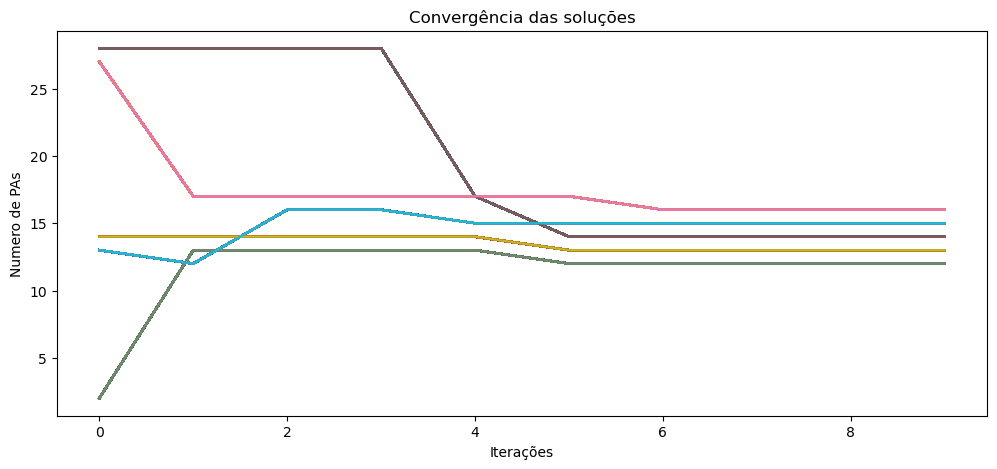

KeyboardInterrupt: 

In [ ]:
# Graficos para visualização das soluções

import matplotlib.pyplot as plt
import random


# Função para plotar os PAs e os clientes em um grid
def plot_progress(progress, i):
    # Criar uma nova figura
    plt.figure(figsize=(12, 5))

    # Plotar resultados
    for i in range(i):
      plt.plot(progress[0]['fitness'], label='Fitness 1')
      plt.plot(progress[1]['fitness'], label='Fitness 2')
      plt.plot(progress[2]['fitness'], label='Fitness 3')
      plt.plot(progress[3]['fitness'], label='Fitness 4')
      plt.plot(progress[4]['fitness'], label='Fitness 5')
      # plt.scatter(client_coordinates[:, 0], client_coordinates[:, 1], marker='o', color='blue', label='Clientes')

    # Adicionar legendas e título
    plt.xlabel('Iterações')
    plt.ylabel('Numero de PAs')
    plt.title('Convergência das soluções')
    #plt.legend()

    # Mostrar o gráfico
    plt.show()

def cor_vibrante():
    # Gerar valores RGB mais vibrantes
    r = random.randint(180, 255)  # Valor de vermelho entre 180 e 255
    g = random.randint(0, 255)    # Valor de verde entre 0 e 255
    b = random.randint(0, 255)    # Valor de azul entre 0 e 255

    # Converter para formato hexadecimal
    cor_hex = "#{:02x}{:02x}{:02x}".format(r, g, b)
    return cor_hex


# Função para plotar os PAs e os clientes em um grid
def plot_solution(solution, client_coordinates):
    # Criar uma nova figura
    plt.figure(figsize=(8, 8))

    # Plotar o grid
    plt.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Definindo as cores RGB para os 30 pontos de acesso
    cores_acesso = [cor_vibrante() for _ in range(30)]

    # Plotar os PAs
    pa_coordinates = solution['pa_coordinates']
    posicao_cliente = solution['client_coordinates']

    # Plotar os clientes
    for i in range(num_pa_locations):
      for j in range(num_clients):
        if solution['x'][i, j] == 1:
          plt.scatter(pa_coordinates[i, 0], pa_coordinates[i, 1], marker='s', c='black', label='Pontos de Acesso')
          plt.scatter(posicao_cliente[j, 0], posicao_cliente[j, 1], marker='o', c=cores_acesso[i], label='Clientes')

    # Adicionar legendas e título
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title('Pontos de Acesso e Clientes')
    #plt.legend()

    # Mostrar o gráfico
    plt.show()

# Plotar curva de convergencia
plot_progress(progress,1000)


# Carrega os dados dos clientes do arquivo CSV
clients_data = get_clients()

# Extrai as coordenadas dos clientes do array
client_coordinates = clients_data[:, :2]

# Plotar a solução da função objetivo 1
for i in range(5):
   plot_solution(best_solution[i], client_coordinates)

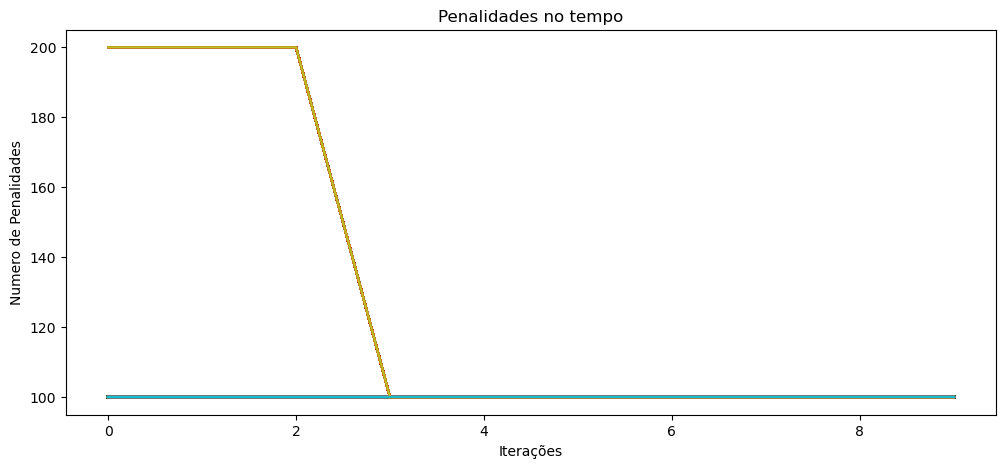

In [ ]:
# Função para plotar os PAs e os clientes em um grid
def plot_progress(progress, i):
    # Criar uma nova figura
    plt.figure(figsize=(12, 5))

    # Plotar resultados
    for i in range(i):
      plt.plot(progress[0]['penalty'], label='Penalidade 1')
      plt.plot(progress[1]['penalty'], label='Penalidade 2')
      plt.plot(progress[2]['penalty'], label='Penalidade 3')
      plt.plot(progress[3]['penalty'], label='Penalidade 4')
      plt.plot(progress[4]['penalty'], label='Penalidade 5')
      # plt.scatter(client_coordinates[:, 0], client_coordinates[:, 1], marker='o', color='blue', label='Clientes')

    # Adicionar legendas e título
    plt.xlabel('Iterações')
    plt.ylabel('Numero de Penalidades')
    plt.title('Penalidades no tempo')
    #plt.legend()

    # Mostrar o gráfico
    plt.show()



# Plotar curva de penalidade
plot_progress(progress,1000)
